# Assignment
I'm actually going to work with a new dataset that I've been meaning to parse.  It is mostly numerical, but it does contain one important categorical variable.  The objective is to find the variables that best predict the arsenic content in water samples from the city of Durango, Mexico.  I'm going to format this one for publication.

# Predictors of arsenic content in goundwater
\[Details about where the data came from\]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import category_encoders as ce
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)  # Unlimited columns

## Data cleanup

In [2]:
df = pd.read_excel('RESULTADOS MUESTREO DURANGO GLOBAL FINAL 2018 REV1.xlsx',
               sheet_name='Resultados Muestreo Durango')

In [3]:
# Initial state of the dataframe
print(df.shape)
df.head()

(146, 22)


,Municipio,Localidad,Coordenadas,Unnamed: 3,Muestra,FECHA DE MUESTREO,pH,Conductividad (μs/cm),As (μg/L),Flúor (mg/L),Na+ (mg/L),K+ (mg/L),Fe+ (mg/L),Ca+ (mg/L),Mg+ (mg/L),NO3- (mg/L),Cl- (mg/L),CO3-2 (mg/L),HCO3- (mg/L),Alcalinidad total (mg CaCO3/L),SO4,Tipo de Agua
0,NaN,NaN,Longitud,Latitud,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Durango,El Nayar,-104.695,23.9629,60.0,2017-08-08,8.140,337.0,61.5,3.15,40.9220,1.4075,0.007,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615,BICARBONATADA SODICA
2,Durango,Sebastián Lerdo de Tejada,-104.64,23.9572,61.0,2017-08-08,8.110,406.0,38.5,2.60,45.8850,0.6100,NaN,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445,BICARBONATADA SODICA
3,Durango,Felipe Ángeles,-104.557,23.9351,62.0,2017-08-08,8.375,384.1,26.5,1.40,38.5360,6.3665,NaN,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730,BICARBONATADA SODICA
4,Durango,Villa Montemorelos,-104.482,23.9918,63.0,2017-08-08,8.500,557.5,23.5,1.20,31.6805,6.7350,NaN,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245,BICARBONATADA CALCICA Y/O MAGNESICA


In [4]:
# I rename all columns with simpler English names
df2 = df.rename(
    {'Municipio':'municipality',
     'Localidad':'town',
     'Coordenadas':'longitude',
     'Unnamed: 3':'latitude',
     'Muestra':'id',
     'FECHA DE MUESTREO ':'sampling_date',
     'pH':'pH',
     'Conductividad (μs/cm)':'conductivity',
     'As (μg/L)':'As',
     'Flúor (mg/L)':'F',
     'Na+ (mg/L)':'Na',
     'K+    (mg/L)':'K',
     'Fe+ (mg/L)':'Fe',
     'Ca+ (mg/L)':'Ca',
     'Mg+ (mg/L)':'Mg',
     'NO3- (mg/L)':'nitrate',
     'Cl- (mg/L)':'Cl',
     ' CO3-2 (mg/L)':'carbonate',
     'HCO3- (mg/L)':'bicarbonate',
     'Alcalinidad total                (mg CaCO3/L)':'total_alcalinity',
     'SO4':'sulfate',
     'Tipo de Agua':'water_type'}, axis='columns')

# The first row is garbage
df2 = df2.drop(index=0)

# The id column shouldn't have any predictive power
df2 = df2.drop(columns='id')

# The column for iron (Fe) is the only one with null values, and has 128/146. 
# Probably not worth fixing, so I'll drop it.
df2 = df2.drop(columns='Fe')

# I assume that the sampling date is not important.
df2 = df2.drop(columns='sampling_date')

# I counted the null values in latitude/longitude.
# Only three rows are missing their values, so I'll manually assign
# them coordinates for the corresponding towns (from Google Maps).
df2.at[62,'longitude'] = -104.703473
df2.at[62,'latitude'] = 24.024753

df2.at[53,'longitude'] = -105.555699
df2.at[53,'latitude'] = 25.461704

df2.at[73,'longitude'] = -104.643166
df2.at[73,'latitude'] = 24.041459

# Those two columns also need to be converted into number type
df2.latitude = df2.latitude.astype('float64')
df2.longitude = df2.longitude.astype('float64')

# I'll also reorder the columns a bit
df2 = df2[['As', # Dependent variable first
 'pH',
 'conductivity',
 'F',
 'Na',
 'K',
 'Ca',
 'Mg',
 'nitrate',
 'Cl',
 'carbonate',
 'bicarbonate',
 'total_alcalinity',
 'sulfate',
 'latitude',
 'longitude',
 'water_type', # Categorical features last
 'municipality',
 'town',
]]

In [5]:
# Confirming correct data types
df2.dtypes

As                  float64
pH                  float64
conductivity        float64
F                   float64
Na                  float64
K                   float64
Ca                  float64
Mg                  float64
nitrate             float64
Cl                  float64
carbonate           float64
bicarbonate         float64
total_alcalinity    float64
sulfate             float64
latitude            float64
longitude           float64
water_type           object
municipality         object
town                 object
dtype: object

In [6]:
# Confirming absence of nulls
df2.isnull().sum()

As                  0
pH                  0
conductivity        0
F                   0
Na                  0
K                   0
Ca                  0
Mg                  0
nitrate             0
Cl                  0
carbonate           0
bicarbonate         0
total_alcalinity    0
sulfate             0
latitude            0
longitude           0
water_type          0
municipality        0
town                0
dtype: int64

In [7]:
# Brief look at the clean dataframe
print(df2.shape)
df2.head()

(145, 19)


,As,pH,conductivity,F,Na,K,Ca,Mg,nitrate,Cl,carbonate,bicarbonate,total_alcalinity,sulfate,latitude,longitude,water_type,municipality,town
1,61.5,8.140,337.0,3.15,40.9220,1.4075,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615,23.96292,-104.69545,BICARBONATADA SODICA,Durango,El Nayar
2,38.5,8.110,406.0,2.60,45.8850,0.6100,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445,23.95718,-104.64026,BICARBONATADA SODICA,Durango,Sebastián Lerdo de Tejada
3,26.5,8.375,384.1,1.40,38.5360,6.3665,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730,23.93505,-104.55661,BICARBONATADA SODICA,Durango,Felipe Ángeles
4,23.5,8.500,557.5,1.20,31.6805,6.7350,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245,23.99177,-104.48167,BICARBONATADA CALCICA Y/O MAGNESICA,Durango,Villa Montemorelos
5,97.5,8.330,326.1,5.95,45.6745,1.6525,8.5190,0.2100,0.52,5.390,0.0,83.0,83.0,59.880,24.02664,-104.50855,BICARBONATADA SODICA,Durango,Belisario Domínguez


## Training/validation/test sets
It's important to use different datasets for all three functions, so I'll create those datasets now.

In [8]:
# Since sklearn dosn't have a tool for creating a validation dataset,
# I'll write one myself

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
    
    # Ensure set sizes add up to 1
    assert (train_size + val_size + test_size == 1), "The sizes of the datasets must add up to 1!"
    
    # Divide data into 'test' and leftovers
    X_leftovers, X_test, y_leftovers, y_test = train_test_split(
    X, y, test_size=test_size, 
    random_state=random_state, shuffle=shuffle)
    
    # Divide leftovers into 'train' and 'validate'
    X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, train_size=(train_size / (train_size + val_size)),
    random_state=random_state, shuffle=shuffle)
    
    # Print out the shapes of the datasets, to confirm that they're
    # what we expect
    
    print(f'X_train   : {X_train.shape}')
    print(f'X_validate: {X_validate.shape}')
    print(f'X_test    : {X_test.shape}')
    print()
    print(f'y_train   : {y_train.shape}')
    print(f'y_validate: {y_validate.shape}')
    print(f'y_test    : {y_test.shape}')
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [9]:
X = df2.drop(columns='As')
y = df2['As']
X_train, X_validate, X_test, y_train, y_validate, y_test = train_validation_test_split(X, y, random_state=42)

X_train   : (128, 18)
X_validate: (17, 18)
X_test    : (15, 18)

y_train   : (128,)
y_validate: (17,)
y_test    : (15,)


/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


I'll store `X_test` and `y_test` for later, and carry out all further training and validation with the other datasets only.

## Data Exploration
Let's take a quick look at what Arsenic levels are present in our training data.

/anaconda3/envs/sandbox/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


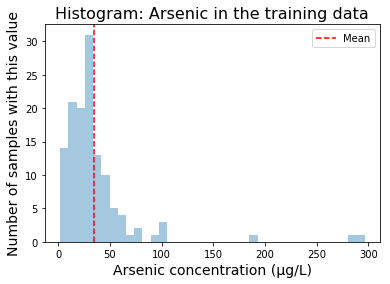

In [10]:
fig, ax = plt.subplots()
ax = sns.distplot(y_train, norm_hist=False, kde=False);
ax.set_xlabel('Arsenic concentration (µg/L)', fontsize=14)
ax.set_ylabel('Number of samples with this value', fontsize=14)
plt.axvline(x=35, color='r', linestyle='--', label='Mean');
plt.legend();
plt.title('Histogram: Arsenic in the training data', fontsize=16);

In [11]:
# And the mean value is..
np.mean(y_train)

35.54412444835938

## Model fitting

In [12]:
# I print out these scores a lot, so I'll write a function to do it
def score_predictions(y_validate, y_pred):
    RMSE = np.sqrt(mean_squared_error(y_validate, y_pred))
    r2 = r2_score(y_validate, y_pred)   
    return RMSE, r2

# Because I want to keep track of the results from several models, 
# I'll create a dataframe to track them.
scorecard = pd.DataFrame(columns = ['Model', 'RMSE', 'R2'])

### Baseline
I'll start with the simplest possible model: assuming that all wells have an arsenic concentration equal to the mean of the training set.  This will provide a baseline score that I can use to judge more complex models.

In [13]:
y_pred = [np.mean(y_train)] * len(y_validate)
RMSE, R2 = score_predictions(y_validate, y_pred)
scorecard = scorecard.append({'Model':'Mean Everywhere', 'RMSE':RMSE, 'R2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R2
0,Mean Everywhere,23.003692,-0.033905


## Linear Regression fit to water quality
First, I'll use only the numerical features related to water quality (measurements of pH, conductivity, and ions).

In [14]:
X_train_ions = X_train.drop(columns=['latitude','longitude','water_type','municipality','town'])
X_validate_ions = X_validate.drop(columns=['latitude','longitude','water_type','municipality','town'])

model = LinearRegression()
model.fit(X_train_ions, y_train)
y_pred = model.predict(X_validate_ions)

RMSE, R2 = score_predictions(y_validate, y_pred)
scorecard = scorecard.append({'Model':'Linear Regression, unscaled', 'RMSE':RMSE, 'R2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R2
0,Mean Everywhere,23.003692,-0.033905
1,"Linear Regression, unscaled",21.840844,0.067982


Teeny improvements. At least the R2 is positive now.

In [15]:
# Note that the R^2 score is actually much highe than 0.067 for the
# training set.  Which shows the importance of good validation.
model.score(X_train_ions, y_train)

0.403680544767595

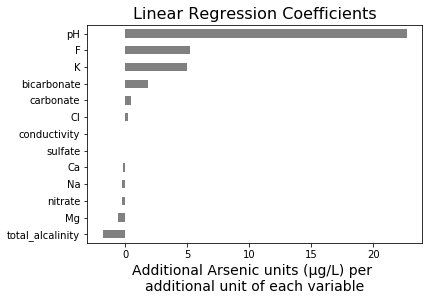

In [16]:
# What coefficients are the most important?
plt.figure()
plt.title('Linear Regression Coefficients', fontsize=16)
coefficients = model.coef_
feature_names = X_validate_ions.columns
ax = pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');
ax.set_xlabel('Additional Arsenic units (µg/L) per \nadditional unit of each variable', fontsize=14);

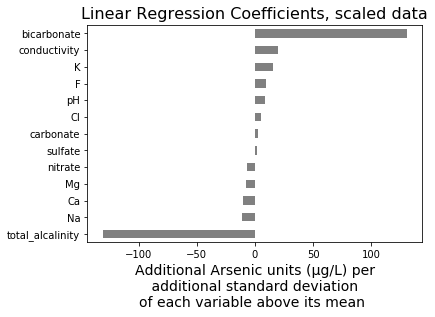

In [17]:
# The previous graph is more useful when the data is scaled to a mean
# of 0 and a standard deviation of 1.  I'll use pipeline to both the
# scaling and model fitting together
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X_train_ions, y_train)

plt.figure()
plt.title('Linear Regression Coefficients, scaled data', fontsize=16)
coefficients = pipeline.named_steps['linearregression'].coef_
feature_names = X_validate_ions.columns
ax = pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');
ax.set_xlabel('Additional Arsenic units (µg/L) per\n additional standard deviation \nof each variable above its mean ', fontsize=14);

This graph shows us one measure of the relative importance of all the variables in `X_train_ions`.

In [18]:
y_pred = pipeline.predict(X_validate_ions)

RMSE, R2 = score_predictions(y_validate, y_pred)
scorecard = scorecard.append({'Model':'Linear Regression, scaled', 'RMSE':RMSE, 'R2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R2
0,Mean Everywhere,23.003692,-0.033905
1,"Linear Regression, unscaled",21.840844,0.067982
2,"Linear Regression, scaled",21.840844,0.067982


Unfortunately, as the scorecard shows, scaling data doesn't improve the predictions of linear regression.

### Ridge regression to water quality
I suspect that a problem here is that we have too many variables and not enough data points. Ridge Regression should be better able than linear regression to deal with potentially under-determined models.  I'll try this one before making the problem worse by adding more variables.  For this first use of Ridge Regression, I'll use the default value of alpha (the ridge regularization strength).

In [19]:
# Ridge Regression, alpha=1.0
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
pipeline.fit(X_train_ions, y_train)
y_pred = pipeline.predict(X_validate_ions)

RMSE, R2 = score_predictions(y_validate, y_pred)
scorecard = scorecard.append({'Model':'Ridge Regression', 'RMSE':RMSE, 'R2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R2
0,Mean Everywhere,23.003692,-0.033905
1,"Linear Regression, unscaled",21.840844,0.067982
2,"Linear Regression, scaled",21.840844,0.067982
3,Ridge Regression,22.790050,-0.014790


Even worse?! 

Ridge Regression didn't improve the score at all... at least not with the default value of alpha. But what if optimize the parameter?  I'm going to run this model over and over again with different values of alpha (ridge regularization strength), until I find a metric that minimizes the root mean square error. Note that for this metaparameter optimization I'll be fitting the model to the (larger) training dataset.  I'll then apply the fitted model to the validation dataset.

In [20]:
print('               alpha > RMSE')
for alpha in ([0] + np.logspace(-9,15, num=10).tolist()):
    pipeline = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    pipeline.fit(X_train_ions, y_train)
    RMSE = np.sqrt(mean_squared_error(y_train,
                        pipeline.predict(X_train_ions)))
    print(f'{alpha:20.10f} > {RMSE:.2f}')

               alpha > RMSE
        0.0000000000 > 31.10
        0.0000000010 > 31.10
        0.0000004642 > 31.10
        0.0002154435 > 31.10
        0.1000000000 > 31.20
       46.4158883361 > 32.60
    21544.3469003188 > 40.17
 10000000.0000000000 > 40.28
4641588833.6127538681 > 40.28
2154434690031.8779296875 > 40.28
1000000000000000.0000000000 > 40.28


Hmmm.  Looks like linear regression (equivalent to alpha=0) performs just as well as ridge regression with any other value of alpha. Incidentally, this printout also shows that Ridge Regression with alpha=1.0 should be essentially equivalent to a Linear Regression. At least in the RMSE that it achieves.

The same is not true of the coefficients, however. Ridge regression penalizes coefficients that become too large, so we expect that coefficients will now have more uniform values. To my surprise, they also changed order somewhat.

In fact, I tried several values of alpha and saw that the relative order and value of the coefficients changed even as the RMSE stayed the same. Thus, the particular order of the coefficients below is NOT a good indication of their relative importance. Here are a few examples (and remember, a Ridge Regression with alpha=0 is identical to Linear Regression in every way)

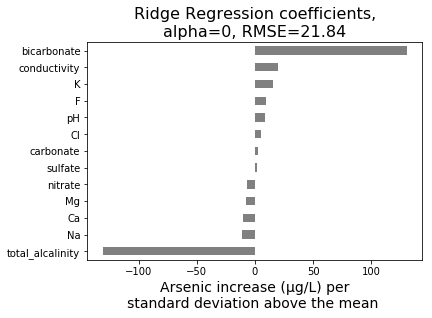

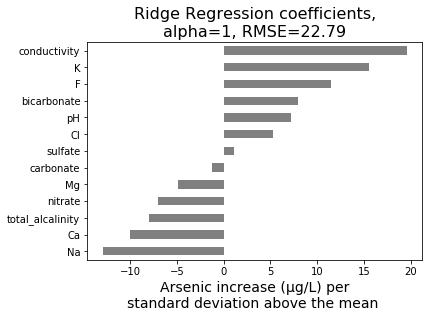

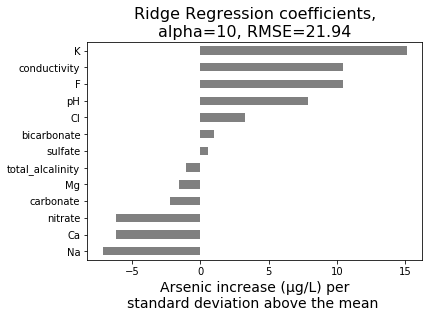

In [21]:
# I re-define pipeline to the values used before I tried to 
# optimize alpha
for alpha in [0,1,10]:
    pipeline = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    pipeline.fit(X_train_ions, y_train)
    y_pred = pipeline.predict(X_validate_ions)
    RMSE, R2 = score_predictions(y_validate, y_pred)
    
    plt.figure()
    plt.title(f'Ridge Regression coefficients,\nalpha={alpha}, RMSE={RMSE:.2f}',
              fontsize=16)
    coefficients = pipeline.named_steps['ridge'].coef_
    feature_names = X_validate_ions.columns
    ax = pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');
    ax.set_xlabel('Arsenic increase (µg/L) per\nstandard deviation above the mean ', fontsize=14);

## Principal Component Analysis
I still think that the main problem with this dataset is that we don't have enough datapoints given the number of variables.  So let's reduce that dimensionality to see if we can do better than we have so far.

I'm not sure how many of the principal components to include in these transformations, so I'm going to loop over models that include everywhere from 1 to 12 (all) of the possible PCs. I'll calculate the RMSE and R^2 for each number of included components, and see where the model best predicts the validation set.

In [22]:
# Lists for plotting
RMSE_train_list = []
RMSE_val_list   = []
R2_train_list =  []
R2_val_list   = []

# There were 13 variables originally, so there are 12 principal components
for n_comp in np.arange(1,13):
    pipeline = make_pipeline(
        StandardScaler(), 
        PCA(n_components=n_comp),
        LinearRegression())
    pipeline.fit(X_train_ions, y_train)
    y_pred_val = pipeline.predict(X_validate_ions)
    y_pred_train = pipeline.predict(X_train_ions)

    RMSE_train, R2_train = score_predictions(y_train, y_pred_train)
    RMSE_val, R2_val = score_predictions(y_validate, y_pred_val)
    
    RMSE_train_list.append(RMSE_train)
    RMSE_val_list.append(RMSE_val)
    R2_train_list.append(R2_train)
    R2_val_list.append(R2_val)

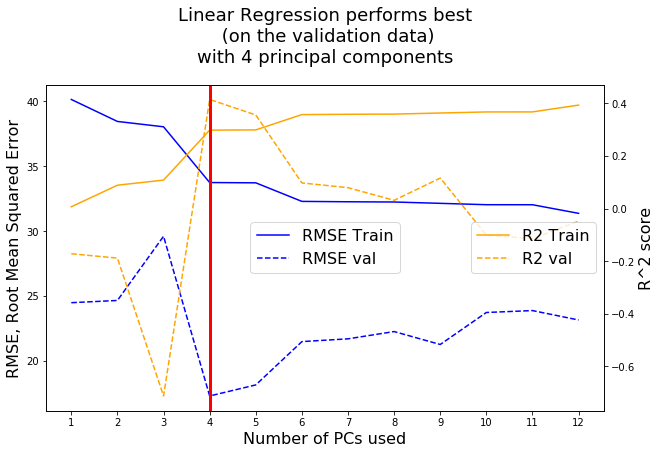

In [23]:
# Plotting it all together...
fig, ax1 = plt.subplots(figsize=(10,6))
x_vals = np.arange(1,13)
ax1.plot(x_vals, RMSE_train_list, color='b', label='RMSE Train')
ax1.plot(x_vals, RMSE_val_list, color='b', linestyle='--', label='RMSE val')
ax1.legend(loc='center', fontsize=16);
ax1.set_ylabel('RMSE, Root Mean Squared Error', fontsize=16);
ax1.set_xlabel('Number of PCs used', fontsize=16);
ax1.set_xticks(x_vals)

ax2 = ax1.twinx()
ax2.plot(x_vals, R2_train_list, color='orange', label='R2 Train')
ax2.plot(x_vals, R2_val_list, color='orange', linestyle='--', label='R2 val')
ax2.legend(loc='center right', fontsize=16);
ax2.set_ylabel('R^2 score', fontsize=16);

ax2.axvline(x=4, color='r', linewidth=3);
plt.title('Linear Regression performs best\n (on the validation data)\nwith 4 principal components',
         fontsize=18, y=1.05);

In [24]:
# Once again with n_components=4, for the scorecard
pipeline = make_pipeline(
    StandardScaler(), 
    PCA(n_components=4),
    LinearRegression())
pipeline.fit(X_train_ions, y_train)
y_pred = pipeline.predict(X_validate_ions)

RMSE, R2 = score_predictions(y_validate, y_pred)
scorecard = scorecard.append({'Model':'PCA with 4 PCs', 'RMSE':RMSE, 'R2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R2
0,Mean Everywhere,23.003692,-0.033905
1,"Linear Regression, unscaled",21.840844,0.067982
2,"Linear Regression, scaled",21.840844,0.067982
3,Ridge Regression,22.790050,-0.014790
4,PCA with 4 PCs,17.304526,0.414934


## Ridge Regression again?
One last thing I could try is to apply Ridge Regression on to the data that is already fit to the ideal PCA, just to see if we get anything better than a linear model for any value of alpha.

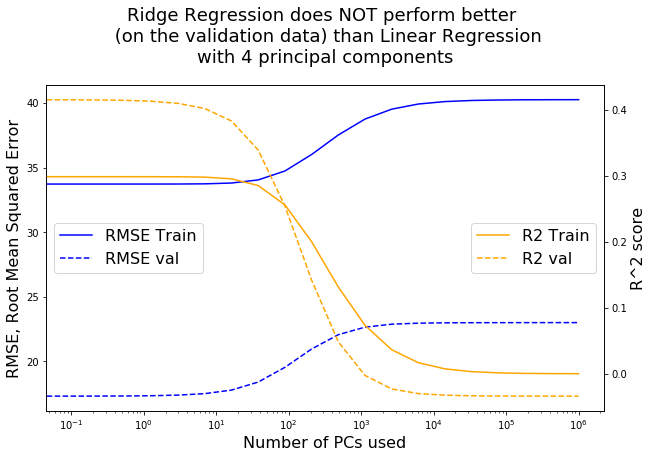

In [25]:
# Lists for plotting
RMSE_train_list = []
RMSE_val_list   = []
R2_train_list =  []
R2_val_list   = []

# I tried out alphas in a broad log-space
x_vals = [0] + np.logspace(-1,6, num=20).tolist()

for alpha in x_vals:
    pipeline = make_pipeline(
        StandardScaler(), 
        PCA(n_components=4),
        Ridge(alpha=alpha))
    pipeline.fit(X_train_ions, y_train)
    y_pred_val = pipeline.predict(X_validate_ions)
    y_pred_train = pipeline.predict(X_train_ions)

    RMSE_train, R2_train = score_predictions(y_train, y_pred_train)
    RMSE_val, R2_val = score_predictions(y_validate, y_pred_val)
    
    RMSE_train_list.append(RMSE_train)
    RMSE_val_list.append(RMSE_val)
    R2_train_list.append(R2_train)
    R2_val_list.append(R2_val)
    
# Plotting it all together...
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(x_vals, RMSE_train_list, color='b', label='RMSE Train')
ax1.plot(x_vals, RMSE_val_list, color='b', linestyle='--', label='RMSE val')
ax1.legend(loc='center left', fontsize=16);
ax1.set_ylabel('RMSE, Root Mean Squared Error', fontsize=16);
ax1.set_xlabel('Number of PCs used', fontsize=16);
ax1.set_xticks(x_vals)

ax2 = ax1.twinx()
ax2.plot(x_vals, R2_train_list, color='orange', label='R2 Train')
ax2.plot(x_vals, R2_val_list, color='orange', linestyle='--', label='R2 val')
ax2.legend(loc='center right', fontsize=16);
ax2.set_ylabel('R^2 score', fontsize=16);

plt.title('Ridge Regression does NOT perform better \n (on the validation data) than Linear Regression\nwith 4 principal components',
         fontsize=18, y=1.05);

plt.xscale('log')

Results are in.  Ridge Regression is indistinguishable from Linear Regression at low alphas, and stays that way until it starts getting smoothly worse (around alpha=1).  Thus, there is no advantage from this model.  In retrospect, that makes sense.  We've already drastically reduced the dimensionality of the data by using PCA, so the extra ridge regression shouldn't add much.

# What about the other variables?
We could add in the other variables, including the categoricals, provided that we one-hot encode them so that regression will work.  All these added dimensions will definitely require PCA to reduce them, so I'll go right into it. Also, this time I won't create all possible PCs.  I'll stop once they've explained 95% of the variance, which shouldn't take many more PCs than the 8 it took last time \[data not shown\]. Throughout these cells I'm fitting to X_train, which contains all the variables we have.

In [ ]:
# Lists for plotting
RMSE_train_list = []
RMSE_val_list   = []
R2_train_list =  []
R2_val_list   = []

# There are lots more PCs this time, especially given the one-hot encoded variables
# Let's see how the scores vary over the first 30
for n_comp in np.arange(1,30):
    pipeline = make_pipeline(
        ce.OneHotEncoder(use_cat_names=True),
        StandardScaler(), 
        PCA(n_components=n_comp),
        LinearRegression())
    pipeline.fit(X_train, y_train)
    y_pred_val = pipeline.predict(X_validate)
    y_pred_train = pipeline.predict(X_train)

    RMSE_train, R2_train = score_predictions(y_train, y_pred_train)
    RMSE_val, R2_val = score_predictions(y_validate, y_pred_val)

    RMSE_train_list.append(RMSE_train)
    RMSE_val_list.append(RMSE_val)
    R2_train_list.append(R2_train)
    R2_val_list.append(R2_val)

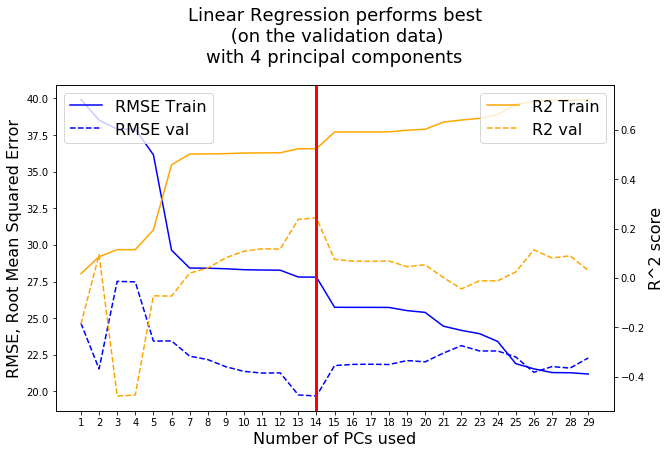

In [27]:
# Plotting it all together...
fig, ax1 = plt.subplots(figsize=(10,6))
x_vals = np.arange(1,30)
ax1.plot(x_vals, RMSE_train_list, color='b', label='RMSE Train')
ax1.plot(x_vals, RMSE_val_list, color='b', linestyle='--', label='RMSE val')
ax1.legend(loc='upper left', fontsize=16);
ax1.set_ylabel('RMSE, Root Mean Squared Error', fontsize=16);
ax1.set_xlabel('Number of PCs used', fontsize=16);
ax1.set_xticks(x_vals)

ax2 = ax1.twinx()
ax2.plot(x_vals, R2_train_list, color='orange', label='R2 Train')
ax2.plot(x_vals, R2_val_list, color='orange', linestyle='--', label='R2 val')
ax2.legend(loc='upper right', fontsize=16);
ax2.set_ylabel('R^2 score', fontsize=16);

ax2.axvline(x=14, color='r', linewidth=3);
plt.title('Linear Regression performs best\n (on the validation data)\nwith 4 principal components',
         fontsize=18, y=1.05);

Once again, varying the number of PCs brings us to a clear minimum for RMSE and maximum for R^2 (now at 14 PCs). But how does it compare to the previous predictions?

In [28]:
# Once more, with 14 PCs, for the scorecard
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(), 
    PCA(n_components=14),
    LinearRegression())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_validate)

RMSE, R2 = score_predictions(y_validate, y_pred)
scorecard = scorecard.append({'Model':'PCA with all categoricals and 14 PCs', 'RMSE':RMSE, 'R2':R2},
                ignore_index=True)
scorecard

/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,Model,RMSE,R2
0,Mean Everywhere,23.003692,-0.033905
1,"Linear Regression, unscaled",21.840844,0.067982
2,"Linear Regression, scaled",21.840844,0.067982
3,Ridge Regression,22.790050,-0.014790
4,PCA with 4 PCs,17.304526,0.414934
5,PCA with all categoricals and 14 PCs,19.685165,0.242882


It's actually worse than before, both in RMSE and R^2!  I bet that it's because at least two of those other categorical variables, town and municipality, probably add more noise than they add signal. Each of those variables is represented at most by a small handful of rows, which means that they make the model more complex without adding much value.  In fact, I bet that the same is true of Latitude and Longitude.  For one final iteration, I'm going to get rid of all those but leave the one other categorical variable that might help: water_type.

In [29]:
X_train.head()

,pH,conductivity,F,Na,K,Ca,Mg,nitrate,Cl,carbonate,bicarbonate,total_alcalinity,sulfate,latitude,longitude,water_type,municipality,town
134,8.065,314.40,2.95450,35.1325,2.1205,30.6665,0.1525,7.46500,7.75050,0.0,156.975,156.975,16.87155,24.038000,-104.655000,BICARBONATADA SODICA,Durango,Col Armando del Castillo Pozo
101,8.610,262.45,0.72300,49.2290,1.6850,9.1260,0.0600,3.23995,9.85105,0.0,108.900,108.900,40.47745,25.767400,-103.338650,BICARBONATADA SODICA,Gómez Palacio,Gómez Palacio
102,7.620,726.05,0.43150,56.8295,4.2700,92.9555,5.7600,26.18605,12.51870,0.0,262.350,262.350,94.55740,25.779050,-103.349110,BICARBONATADA CALCICA Y/O MAGNESICA,Gómez Palacio,Venecia
95,7.525,2207.00,0.34450,255.5550,8.1500,126.6250,53.2200,8.07560,14.18490,0.0,297.000,297.000,163.62820,25.526027,-103.612927,BICARBONATADA SODICA,Lerdo,León Guzmán
137,8.215,176.65,3.51955,20.1690,1.0780,14.3120,0.0365,2.10865,0.00000,9.9,109.200,109.200,7.97180,24.051000,-104.685000,BICARBONATADA SODICA,Durango,Col. Morga Pozo


# My best guess
I'm now going to use only the variables related to water quality.  That's all the numericals from before, plus water_type (which must be one-hot encoded).

In [ ]:
X_train_best = X_train.drop(columns=['latitude','longitude','municipality','town'])
X_validate_best = X_validate.drop(columns=['latitude','longitude','municipality','town'])

# Lists for plotting
RMSE_train_list = []
RMSE_val_list   = []
R2_train_list =  []
R2_val_list   = []

# There are lots more PCs this time, especially given the one-hot encoded variables
# Let's see how the scores vary over the first 20
for n_comp in np.arange(1,20):
    pipeline = make_pipeline(
        ce.OneHotEncoder(use_cat_names=True),
        StandardScaler(), 
        PCA(n_components=n_comp),
        LinearRegression())
    pipeline.fit(X_train_best, y_train)
    y_pred_val = pipeline.predict(X_validate_best)
    y_pred_train = pipeline.predict(X_train_best)

    RMSE_train, R2_train = score_predictions(y_train, y_pred_train)
    RMSE_val, R2_val = score_predictions(y_validate, y_pred_val)

    RMSE_train_list.append(RMSE_train)
    RMSE_val_list.append(RMSE_val)
    R2_train_list.append(R2_train)
    R2_val_list.append(R2_val)

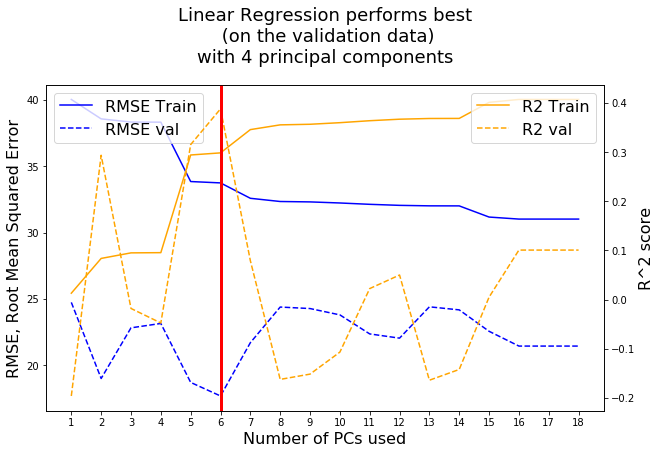

In [33]:
# Plotting it all together...
fig, ax1 = plt.subplots(figsize=(10,6))
x_vals = np.arange(1,19)
ax1.plot(x_vals, RMSE_train_list, color='b', label='RMSE Train')
ax1.plot(x_vals, RMSE_val_list, color='b', linestyle='--', label='RMSE val')
ax1.legend(loc='upper left', fontsize=16);
ax1.set_ylabel('RMSE, Root Mean Squared Error', fontsize=16);
ax1.set_xlabel('Number of PCs used', fontsize=16);
ax1.set_xticks(x_vals)

ax2 = ax1.twinx()
ax2.plot(x_vals, R2_train_list, color='orange', label='R2 Train')
ax2.plot(x_vals, R2_val_list, color='orange', linestyle='--', label='R2 val')
ax2.legend(loc='upper right', fontsize=16);
ax2.set_ylabel('R^2 score', fontsize=16);

ax2.axvline(x=6, color='r', linewidth=3);
plt.title('Linear Regression performs best\n (on the validation data)\nwith 4 principal components',
         fontsize=18, y=1.05);

Aha! The extra variables have increased the ideal number of PCs to 6. But does it make the score better?

In [36]:
# Once more, with 14 PCs, for the scorecard
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(), 
    PCA(n_components=6),
    LinearRegression())
pipeline.fit(X_train_best, y_train)
y_pred = pipeline.predict(X_validate_best)

RMSE, R2 = score_predictions(y_validate, y_pred)
scorecard = scorecard.append({'Model':'PCA with water quality only, and 6 PCs', 'RMSE':RMSE, 'R2':R2},
                ignore_index=True)
scorecard

/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


,Model,RMSE,R2
0,Mean Everywhere,23.003692,-0.033905
1,"Linear Regression, unscaled",21.840844,0.067982
2,"Linear Regression, scaled",21.840844,0.067982
3,Ridge Regression,22.790050,-0.014790
4,PCA with 4 PCs,17.304526,0.414934
5,PCA with all categoricals and 14 PCs,19.685165,0.242882
6,"PCA with water quality only, and 6 PCs",17.699638,0.387912


# Conclusion
It looks like nothing can improve upon the ideal PCA with just the numerical variables associated with water quality. Even that other categorical variable that seems both related and useful, `water_type`, doesn't add any predictive power judging by our validation set.

I am ready to declare that I have the best possible model for this data... and finally test in on the test data. 

In [ ]:
X_test_best = X_test.drop(columns=['latitude','longitude','municipality','town'])

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(), 
    PCA(n_components=6),
    LinearRegression())
pipeline.fit(X_train_best, y_train)
y_pred = pipeline.predict(X_test_best)

RMSE, R2 = score_predictions(y_test, y_pred)

In [43]:
# Drumroll...
print(f'RMSE for test data: {RMSE}')
print(f'R^2 for test data : {R2}')

RMSE for test data: 18.484371204183745
R^2 for test data : -0.17200568842409725


Eh... 

Well, the RMSE is really low, comparable to the best that I saw with the validation dataset.  I'm not sure what's going on with R^2.  Luckily, RMSE is the more important value. I declare that this model works!